# Setting up packages (Note: new ones maybe added as we progress)

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from numpy import round
from pylab import *
%matplotlib inline

# Set up some basic functions

In [5]:
# Set up for barycentric weights
def barywts(x):
    with errstate(divide='ignore',invalid='ignore'):
        w=prod(x[:,newaxis]-x+eye(len(x)),1)
    w=1./w
    return w

# chebyshev weights for N+1 chebyshev points of the first kind (usually with three condions)
def chebwts(N):
    w=(-1.)**arange(N+1)
    w[0]/=2.0;w[-1]/=2.0
    return w

# construction of Lagrange differentiation matrix
def diffmat(x):
    N=len(x) 
    w=barywts(x) # Compute the barycentric weights for x
    D=zeros((N,N)) # initialize the differentiation matrix
    for i in range(N):
        with errstate(divide='ignore',invalid='ignore'):
            D[i,:]=w/w[i]/(x[i]-x) # Formula we derived by differentiating each lagrange polynomial and evaluating at the same nodes
        D[i,i]=0. # Set the i,i entry to zero so we can sum the rows to get the diagonal entry.
        D[i,i]=-sum(D[i,:]) # symmetry condition to avoid the round off error
    return D

# construction of Chebyshev differentiation matrix
def chebmat(N):
    D=zeros((N+1,N+1))
    w=chebwts(N)
    x=chebpts(N)
    D=((w/w[:,newaxis])/(x[:,newaxis]-x+eye(N+1))-eye(N+1))
    D+=diag(-sum(D,1))
    return D
#Chebyshev point of the second kind usally referred to as the extremer
def chebpts(N):
    return cos(pi*arange(N+1)/N)[::-1]

#Chebyshev point of the first kind usually referred to as the root of the Chebyshev polynomial
def chebpts1(N):
    return cos((2*arange(N)+1)*pi/(2*N))[::-1]

#resampling matrix
def barymat(y,x,w):
    N_rows=len(y)
    N_cols=len(x)
    P=zeros((N_rows,N_cols))
    P=w/(y[:,newaxis]-x)
    P=dot(diag(sum(P,1)),P)
    P[isnan(P)]=1.0
    P[isinf(P)]=1.0
    return P
#contruction of the barycentric formula of the second kind
def bary2(x,xk,fk,wk):
    # First initialize the numerator and denominator sums
    numer = zeros(x.size)
    denom = zeros(x.size)
    # loop over all interpolation nodes
    for j in range(xk.size):
        with errstate(divide='ignore',invalid='ignore'):
            temp = wk[j]/(x-xk[j])
            numer = numer+temp*fk[j]
            denom = denom + temp
    with errstate(divide='ignore',invalid='ignore'):
        p = numer / denom

    find=lambda ff:where(ff)[0]
    # replace NaNs (i.e. where the evaluation point is exactly equal to a node)
    for k in find(isnan(p)):
        idx = find( x[k]==xk )
        if idx.size > 0:
            p[k] = fk[idx[0]]
    return p

#contruction of the barycentric formula of the first kind
def bary1(x,xk,fk,wk):
    # First initialize the product and sum terms
    pr = ones(x.size)
    su = zeros(x.size)
    # loop over all interpolation nodes
    for j in range(xk.size):
        # We have a shared term, so we reuse it
        temp = (x-xk[j])
        pr = pr*temp
        with errstate(divide='ignore',invalid='ignore'):
            su = su + wk[j]*fk[j]/temp
    # No multiply sum and product terms
    p = pr*su

    find=lambda ff:where(ff)[0]
    # replace NaNs (i.e. where the evaluation point is exactly equal to a node)
    for k in find(isnan(p)):
        idx = find( x[k]==xk )
        if idx.size > 0:
            p[k] = fk[idx[0]]
    return p

# Bases Implementation

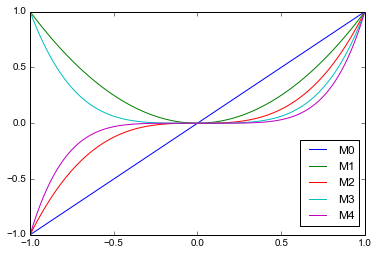

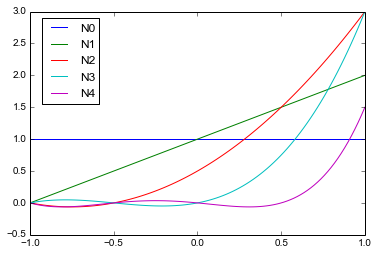

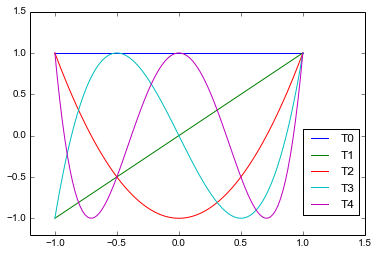

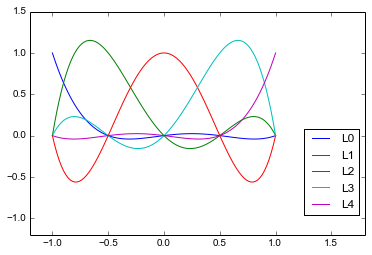

In [6]:
def monomial(k,x):
    phi=ones(x.shape)
    for i in range(k+1):
        phi=x*phi
    return phi

x=linspace(-1,1,100)
for k in range(5):
    y=monomial(k,x)
    plt.plot(x,y,label = "M"  + str(k)) 
plt.legend( bbox_to_anchor=[1, 0.45], 
           loc='best', ncol=1)
plt.figure()

def newton(k,xk,x):
    Nk=ones(x.shape)
    for i in range(k):
        Nk=Nk*(x-xk[i])
    return Nk

N=5
xk=linspace(-1,1,N)
x=linspace(-1,1,100)
f=linspace(-1,1,100)
for k in range(5):
    y=newton(k,xk,x)
    #plt.ylim(-4,12)
    plt.plot(x,y,label = "N"  + str(k))
plt.legend( bbox_to_anchor=[0.018, 0.56], 
          loc='best', ncol=1)
plt.figure()

def cheby(k,x):
    Tkm1=ones(x.shape)
    if k==0:
        return Tkm1
    Tk=x
    for i in range(k-1):
        Tk1=2*x*Tk-Tkm1
        Tkm1=Tk
        Tk=Tk1    
    return Tk

x=linspace(-1,1,100)
for k in range(5):
    y=cheby(k,x)
    plt.ylim(-1.2,1.5)
    plt.xlim(-1.2,1.5)
    plt.plot(x,y,label = "T"  + str(k))
plt.legend( bbox_to_anchor=[1, 0.5], 
           loc='best', ncol=1)
plt.figure()

def lagrange_poly(k,xk, x):
    N=len(xk)
    L=ones(x.shape)
    for n in range(N):
        if k != n:
            L = L*(x - xk[n])/(xk[k] - xk[n])
    return L

N=5
x=linspace(-1,1,100)
xk=linspace(-1,1,N)
for k in range(N):
    y=lagrange_poly(k,xk,x)
    plt.ylim(-1.2,1.5)
    plt.xlim(-1.2,1.8)
    plt.plot(x,y,label = "L"  + str(k))
plt.legend( bbox_to_anchor=[1, 0.5], 
           loc='best', ncol=1)

# Bases P(x) Implementation

In [7]:
def monomial(x,xk,fk):
    N=len(xk)
    A=zeros((N,N))
    A[:,0]=1.0
    for i in range(1,N):
        A[:,i]=A[:,i-1]*xk
    c=solve(A,fk)
    mon_p=zeros(x.shape)
    for i in range(N):
        mon_p=c[N-1-i]+x*mon_p
    return c,mon_p,cond(A)

# to return c,p(x),cond(l)
def lagrange_poly(x, xp, fp):
    f = 0.0
    for m in range(len(xp)):       
        l = None
        for n in range(len(xp)):
            if n == m:
                continue
            if l == None:
                l = (x - xp[n])/(xp[m] - xp[n])
            else:
                l *= (x - xp[n])/(xp[m] - xp[n])
        #c = solve(fp,l) giving error when i tried to evaluate c
        f += fp[m]*l
    #return c,cheb_p,cond(A)
    N=len(xk)
    A=eye(N)
    c=fk
    #wk=barywts(xk)
    #p=bary2(x,xk,fk,wk)
    return c,f,cond(A)

def newton(x,xk,fk):
    N=len(xk)
    A=zeros((N,N))
    A[:,0]=1.0
    A[:,1:]=xk[:,newaxis]-xk[:-1]
    A=cumprod(A,1)
    c=solve(A,fk)
    newt_p=zeros(x.shape)
    for i in range(N):
        newt_p=c[N-1-i]+(x-xk[N-1-i])*newt_p
    return c,newt_p,cond(A)


def chebyshev(x,xk,fk):
    N=len(xk)
    A=zeros((N,N))
    A[:,0]=1.0
    A[:,1]=xk
    for i in range(2,N):
        A[:,i]=2.0*xk*A[:,i-1]-A[:,i-2]
    c=solve(A,fk)
    cheb_p=c[N-1]
    if N>1:
        p1=cheb_p
        cheb_p=c[N-2]+2*x*c[N-1]
        for i in range(N-3,-1,-1):
            p2=p1;p1=cheb_p
            cheb_p=c[i]+2*x*p1-p2
        cheb_p=cheb_p-x*p1
    return c,cheb_p,cond(A)

xk=array([0.2,0.2603,0.4340,0.7,1.0264,1.3736,1.7,1.966,2.1397,2.2])
fk=array([-1.3543,-1.2974,-0.6895,0.1251,-0.0238,0.1753,0.4237,-0.2666,-0.7273,-0.7884])


x=linspace(0.2,2.2,100)
c_mono,p_mono,K_mono=monomial(x,xk,fk)
c_newt,p_newt,K_newt=newton(x,xk,fk)
c_lagr,p_lagr,K_lagr=lagrange_poly(x, xk, fk)
c_cheb,p_cheb,K_cheb=chebyshev(x,xk,fk)


plot(x,p_mono,x,p_newt,x,p_cheb,x,p_lagr,xk,fk,'o')
legend([ 'Monomial', 'Newton', 'Chebyshev','Lagrange', 'Exact Function' ],bbox_to_anchor=[0.7, 0.45], loc='upper right', ncol=1)
show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
lagrange_poly(x, xk, fk)[2]

WHY THIS ERROR  ( FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.) I suspect it is the reason why solve_allbases function is not working

In [8]:
#perturbing the coefficients and then obtain the error between the perturbed coefficients and the initial ones
def solve_allbases(how_many,xk,fk):
    x=xk
    c_mono,_,K_mono=monomial(x,xk,fk)
    c_newt,_,K_newt=newton(x,xk,fk)
    c_lagr,_,K_lagr=lagrange_poly(x,xk,fk)
    c_cheb,_,K_cheb=chebyshev(x,xk,fk)
    er_mono=zeros(how_many)
    er_newt=zeros(how_many)
    er_lagr=zeros(how_many)
    er_cheb=zeros(how_many)
    for i in range(how_many):
        df= np.random.randn(len(xk));df=df/norm(df)*1e-6
        fh=fk+df
        ch_mono,_,_=monomial(x,xk,fh)
        ch_newt,_,_=newton(x,xk,fh)
        ch_lagr,_,_=lagrange_poly(x,xk,fh)
        ch_cheb,_,_=chebyshev(x,xk,fh)

        er_mono[i]=norm(c_mono-ch_mono)/norm(c_mono)
        er_newt[i]=norm(c_newt-ch_newt)/norm(c_newt)
        er_lagr[i]=norm(c_lagr-ch_lagr)/norm(c_lagr)
        er_cheb[i]=norm(c_cheb-ch_cheb)/norm(c_cheb)
    return(er_mono,er_newt,er_lagr,er_cheb)

In [9]:
er_mono,er_newt,er_lagr,er_cheb=solve_allbases(1000,xk,fk)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
_=plt.hist([log10(er) for er in [er_mono,er_newt,er_lagr,er_cheb]])
leg=plt.legend(['Monomial','Newton','Lagrange','Chebyshev'])

NameError: name 'er_mono' is not defined

# Implementation of the comparism between the Chebyshev points and equispaced points

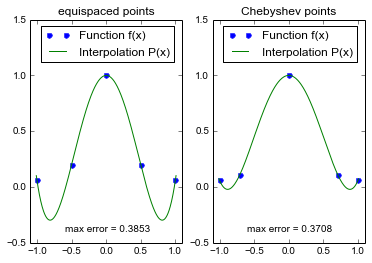

In [11]:
# for lower degree
N = 4
x_lin = arange(-1.01,1.015,0.005)
for i in [1,2]:
    if i==1:
        s = 'equispaced points'; x = -1 + 2.*arange(0,N+1)/N
    if i==2:
        s = 'Chebyshev points';  x = cos(pi*arange(0,N+1)/N)
    subplot(1,2,i)
    u  = 1/(1+16*x**2)
    uu = 1/(1+16*x_lin**2)
    p  = polyfit(x,u,N) #Fit a polynomial of N degree
    pp = polyval(p,x_lin) #Evaluate a polynomial at specific values.
    plot(x,u,'.',markersize=10)
    plot(x_lin,pp)
    xlim(-1.1,1.1); ylim(-0.5,1.5); title(s)
    error = linalg.norm(uu-pp,inf)
    text(-0.6,-0.4,'max error = '+str('%0.4f' % error))
    legend([ 'Function f(x)', 'Interpolation P(x)' ],bbox_to_anchor=[0.03,1], loc='upper left', ncol=1)
show()

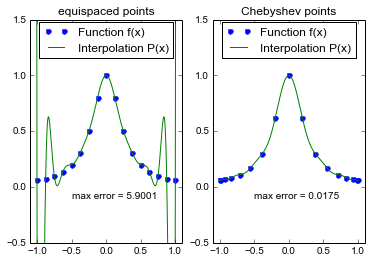

In [12]:
#for high degree
N = 16
x_lin = arange(-1.01,1.015,0.005)
for i in [1,2]:
    if i==1:
        s = 'equispaced points'; x = -1 + 2.*arange(0,N+1)/N
    if i==2:
        s = 'Chebyshev points';  x = cos(pi*arange(0,N+1)/N)
    subplot(1,2,i)
    u  = 1/(1+16*x**2)
    uu = 1/(1+16*x_lin**2)
    p  = polyfit(x,u,N)
    pp = polyval(p,x_lin)
    plot(x,u,'.',markersize=10)
    plot(x_lin,pp)
    xlim(-1.1,1.1); ylim(-0.5,1.5); title(s)
    error = linalg.norm(uu-pp,inf)
    text(-0.5,-0.1,'max error = '+str('%0.4f' % error))
    legend([ 'Function f(x)', 'Interpolation P(x)' ],bbox_to_anchor=[0.5, 0.8], loc='lower center', ncol=1)

show()

/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the

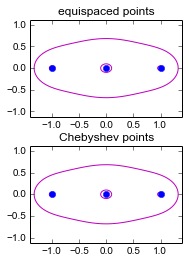

In [13]:
# polynomials and corresponding equipotential curves(allipses) for low degree
from numpy import *
from pylab import *
N = 2
for i in [0,1]:
    if i==0: s = 'equispaced points'; x = linspace(-1.,1.,N+1)
    if i==1: s = 'Chebyshev points' ; x = cos(linspace(0,pi,N+1))
    p = poly(x)
    # Plot equipotential curves:
    subplot(2,2,2*i+2)
    plot(real(x),imag(x),'.',markersize=12)
    xgrid = arange(-1.4,1.42,.02); ygrid = arange(-1.12,1.14,.02)
    xx,yy = meshgrid(xgrid,ygrid); zz = xx+1j*yy       
    pp = polyval(p,zz); levels = 10.**arange(-4,1)
    contour(xx,yy,abs(pp),levels,colors=['m']); title(s);
    subplots_adjust(hspace=.3)
show()

/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/collections.py:609: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the

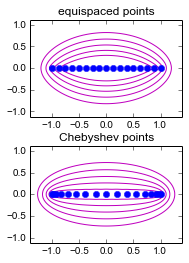

In [14]:
# polynomials and corresponding equipotential curves for high degree
from numpy import *
from pylab import *
N = 16
for i in [0,1]:
    if i==0: s = 'equispaced points'; x = linspace(-1.,1.,N+1)
    if i==1: s = 'Chebyshev points' ; x = cos(linspace(0,pi,N+1))
    p = poly(x)
    # Plot equipotential curves:
    subplot(2,2,2*i+2)
    plot(real(x),imag(x),'.',markersize=12)
    xgrid = arange(-1.4,1.42,.02); ygrid = arange(-1.12,1.14,.02)
    xx,yy = meshgrid(xgrid,ygrid); zz = xx+1j*yy       
    pp = polyval(p,zz); levels = 10.**arange(-4,1)
    contour(xx,yy,abs(pp),levels,colors=['m']); title(s);
    subplots_adjust(hspace=.3)
show()

/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.4/dist-packages/numpy-1.13.0-py3.4-linux-x86_64.egg/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


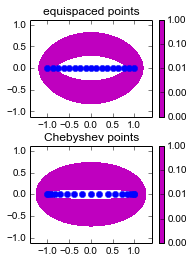

In [15]:
# polynomials and corresponding equipotential curves contour plot
from numpy import *
from pylab import *
N = 16
for i in [0,1]:
    if i==0: s = 'equispaced points'; x = linspace(-1.,1.,N+1)
    if i==1: s = 'Chebyshev points' ; x = cos(linspace(0,pi,N+1))
    p = poly(x)
    # Plot equipotential curves:
    subplot(2,2,2*i+2)
    plot(real(x),imag(x),'.',markersize=12)
    xgrid = arange(-1.4,1.42,.02); ygrid = arange(-1.12,1.14,.02)
    xx,yy = meshgrid(xgrid,ygrid); zz = xx+1j*yy       
    pp = polyval(p,zz); levels = 10.**arange(-4,1)
    t = contourf(xx,yy,abs(pp),colors=['m'],levels=levels); title(s);
    colorbar(t, format="%.2f")
    subplots_adjust(hspace=.3)
show()

In [16]:
#Implementing the Runge function on the two barycentric formula on Chebyshev and equispaced points

In [17]:
#Runge function
f2 = lambda x: 1./(1.+x**2)

In [18]:
x=  linspace(-1,1,100) # do for for N = 30 to see the difference

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply


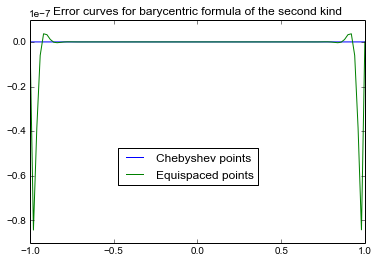

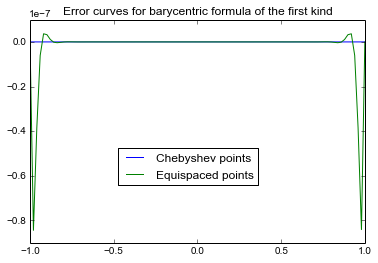

In [19]:
N=30
#N = 20
# Chebyshev points
xc=chebpts(N)
wc=barywts(xc)
f2c=f2(xc)

# Equally spaced points
xu=linspace(-1,1,N)
wu=barywts(xu)
f2u=f2(xu)

# Evaluate functions on the fine grid
f2cx=bary2(x,xc,f2c,wc)
f2ux=bary2(x,xu,f2u,wu)
f2cx_1=bary1(x,xc,f2c,wc)
f2ux_1=bary1(x,xu,f2u,wu)

plt.figure()
plt.plot(x,(f2(x)-f2cx),x,(f2ux-f2(x)));plt.legend(['Chebyshev points','Equispaced points '],bbox_to_anchor=[0.7, 0.45], 
        loc='upper right', ncol=1);plt.title('Error curves for barycentric formula of the second kind')
#plt.ylim(100,20)
plt.figure()
plt.plot(x,(f2cx_1-f2(x)),x,(f2ux_1-f2(x)));plt.legend(['Chebyshev points','Equispaced points'],bbox_to_anchor=[0.7, 0.45], 
                                       loc='best', ncol=1);plt.title('Error curves for barycentric formula of the first kind')
#plt.ylim(100,20)

# Implementing some functions using differentiation matrix, x = Chebyshev grid

In [20]:
# CHEB  compute D = differentiation matrix, x = Chebyshev grid
def cheb(N):
    if N==0: 
        D = 0.; x = 1.
    else:
        n = arange(0,N+1)
        x = cos(pi*n/N).reshape(N+1,1) 
        c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = tile(x,(1,N+1))
        dX = X - X.T
        D = dot(c,1./c.T)/(dX+eye(N+1))
        D -= diag(sum(D.T,axis=0))
    return D, x.reshape(N+1)


In [21]:
set_printoptions(linewidth=200,precision=4)
D,x = cheb(4)
print (D)
print (x)

[[ 5.5    -6.8284  2.     -1.1716  0.5   ]
 [ 1.7071 -0.7071 -1.4142  0.7071 -0.2929]
 [-0.5     1.4142  0.     -1.4142  0.5   ]
 [ 0.2929 -0.7071  1.4142  0.7071 -1.7071]
 [-0.5     1.1716 -2.      6.8284 -5.5   ]]
[  1.0000e+00   7.0711e-01   6.1232e-17  -7.0711e-01  -1.0000e+00]


In [22]:
q = array([1,2,3,4])
diffmat(q)

array([[-1.8333,  3.    , -1.5   ,  0.3333],
       [-0.3333, -0.5   ,  1.    , -0.1667],
       [ 0.1667, -1.    ,  0.5   ,  0.3333],
       [-0.3333,  1.5   , -3.    ,  1.8333]])

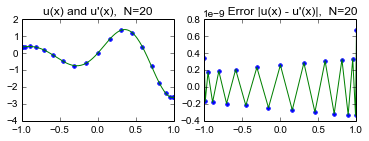

In [23]:
# Chebyshev differentation of a smooth function
from pylab import *
xx = arange(-1,1.01,.01); uu = exp(xx)*sin(5*xx)
for N in [20]:
    D,x = cheb(N); u = exp(x)*sin(5*x)
    subplot(2,2,2*(N==20)+1)
    plot(x,u,'.',markersize=8);    plot(xx,uu)
    xlim(-1,1); ylim(-4,2); title("u(x) and u'(x),  N="+str(N))
    error = dot(D,u) - exp(x)*(sin(5*x)+5*cos(5*x))
    subplot(2,2,2*(N==20)+2)
    plot(x,error,'.',markersize=8);
    plot(x,error)
    xlim(-1,1); title("       Error |u(x) - u'(x)|,  N="+str(N))
show()



Solve

$$
\frac{du}{dx}+0.5u=0
$$

with initial value condition

$$
u(-1)=u_0
$$

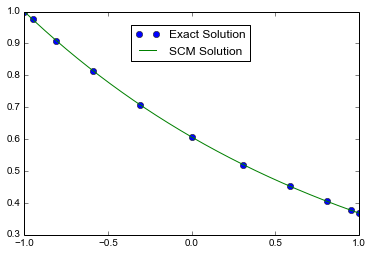

In [24]:
N = 10
xx=linspace(-1,1,1000)
xk = chebpts(N)
wk = barywts(xk)
beta=0.5
u0=1
rhs1=zeros(xk.shape);rhs1[0]=u0  # Set up rhs
D=diffmat(xk) # Differentiation matrix
B=D+diag(beta*ones(xk.shape)) # operator matrix coming from the ODE
B[0,:]=0.;B[0,0]=1 # Replace the first row to enforce the initial condition
u1=linalg.solve(B,rhs1) # Solve for the values of the solution
uu1=bary2(xx,xk,u1,wk)
plt.figure()
plt.plot(xk,u1,'o',xx,uu1)
plt.legend([ 'Exact Solution', 'SCM Solution' ],bbox_to_anchor=[0.3,0.75], loc='best', ncol=1)

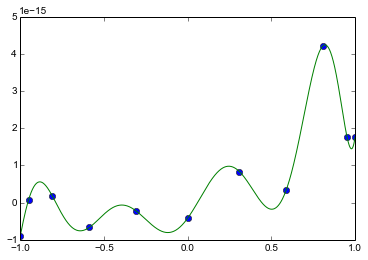

In [25]:
accuracy = dot(B,u1)-rhs1 # how is this accuracy so important?
er1=bary2(xx,xk,accuracy,wk)
plt.plot(xk,accuracy,'o',xx,er1)

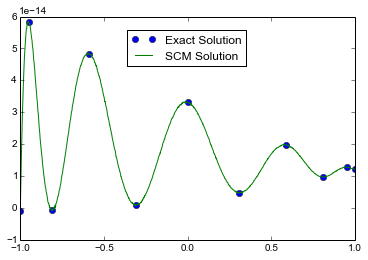

In [26]:
Analytical=lambda x: exp(-beta*(x+1.)) # compare with exact solution
plt.plot(xk,u1-Analytical(xk),'o',xx,uu1-Analytical(xx))
plt.legend([ 'Exact Solution', 'SCM Solution' ],bbox_to_anchor=[0.3,0.75], loc='best', ncol=1)

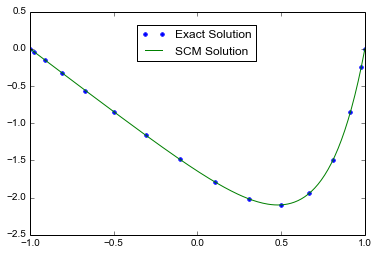

In [27]:
#solve linear BVP u_xx = exp(4x), u(-1)=u(1)=0
from pylab import *
N = 15
D,x = cheb(N)        
D2 = dot(D,D)                      # second derivative
D2 = D2[1:-1,1:-1]                 # boundary conditions
f = exp(4*x[1:-1])           
u = linalg.solve(D2,f)             # Poisson eq. solved here
u = hstack(([0.],u,[0.]))
plot(x,u,'.',markersize=8)
xx = arange(-1,1.01,.01)
uu = polyval(polyfit(x,u,N),xx)    # interpolate grid data
plot(xx,uu)
xlim(-1,1) #grid();
exact = ( exp(4*xx) - sinh(4)*xx - cosh(4) )/16 
#title(' N = 15 ')
#semilogy(xx,uu-exact)
plt.legend([ 'Exact Solution', 'SCM Solution' ],bbox_to_anchor=[0.3,0.75], loc='best', ncol=1)
show()

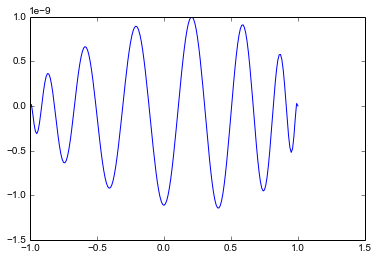

In [28]:
plt.plot(xx,uu-exact)
#title(' N = 15 ')


# RECTANGULAR DIFFERENTIAION MATRIX    What is the difference between the first setup in the first sell and this one because rsampling matrix is presnt in both

In [29]:
# Set up some basic functions
def barywts(x):
    with errstate(divide='ignore',invalid='ignore'):
        w=prod(x[:,newaxis]-x+eye(len(x)),1)
    w=1./w
    return w

# We specialize to chebyshev weights for N+1 chebyshev points of the first kind
def chebwts(N):
    w=(-1.)**arange(N+1)
    w[0]/=2.0;w[-1]/=2.0
    return w

# Differentiation matrix
def diffmat(x):
    N=len(x) # Size of 
    w=barywts(x) # Compute the barycentric weights for x
    D=zeros((N,N)) # initialize the differentiation matrix
    for i in range(N):
        with errstate(divide='ignore',invalid='ignore'):
            D[i,:]=w/w[i]/(x[i]-x) # Formula we derived by differentiating each lagrange polynomial and evaluating at the same nodes
        D[i,i]=0. # Set the i,i entry to zero so we can sum the rows to get the diagonal entry.
        D[i,i]=-sum(D[i,:])
    #D=((w[:,newaxis]/w)/(x[:,newaxis]-x+eye(N))-eye(N))
    #for j in range(N):
    #    D[j,j]=-sum(D[j,:])
    return D

# Here we are going to construct a differentiation matrix for the chebyshev points
def chebmat(N):
    D=zeros((N+1,N+1))
    w=chebwts(N)
    x=chebpts(N)
    D=((w/w[:,newaxis])/(x[:,newaxis]-x+eye(N+1))-eye(N+1))
    D+=diag(-sum(D,1))
    return D

def chebpts(N):
    return cos(pi*arange(N+1)/N)[::-1]
def chebpts1(N):
    return cos((2*arange(N)+1)*pi/(2*N))[::-1]

def barymat(y,x,w):
    N_rows=len(y)
    N_cols=len(x)
    P=zeros((N_rows,N_cols))
    P=w/(y[:,newaxis]-x)
    P=dot(diag(sum(P,1)),P)
    P[isnan(P)]=1.0
    P[isinf(P)]=1.0
    return P

def bary2(x,xk,fk,wk):
    # First initialize the numerator and denominator sums
    numer = zeros(x.size)
    denom = zeros(x.size)
    # loop over all interpolation nodes
    for j in range(xk.size):
        with errstate(divide='ignore',invalid='ignore'):
            temp = wk[j]/(x-xk[j])
            numer = numer+temp*fk[j]
            denom = denom + temp
    with errstate(divide='ignore',invalid='ignore'):
        p = numer / denom

    find=lambda ff:where(ff)[0]
    # replace NaNs (i.e. where the evaluation point is exactly equal to a node)
    for k in find(isnan(p)):
        idx = find( x[k]==xk )
        if idx.size > 0:
            p[k] = fk[idx[0]]
    return p

In [30]:
N=100
xk=(chebpts(N)+1)/2*2*pi;print(xk.shape)
wk=chebwts(N)
yk=(chebpts1(N-1)+1)/2*2*pi;print(yk.shape)
D=diffmat(xk)
P=barymat(yk,xk,wk)

(101,)
(99,)


In [31]:
print(D)

[[ -1.0611e+03   1.2902e+03  -3.2262e+02 ...,  -3.1862e-01   3.1839e-01  -1.5915e-01]
 [ -3.2254e+02   1.6123e+02   2.1510e+02 ...,   1.5935e-01  -1.5923e-01   7.9597e-02]
 [  8.0655e+01  -2.1510e+02   4.0288e+01 ...,  -1.5947e-01   1.5935e-01  -7.9656e-02]
 ..., 
 [  7.9656e-02  -1.5935e-01   1.5947e-01 ...,  -4.0288e+01   2.1510e+02  -8.0655e+01]
 [ -7.9597e-02   1.5923e-01  -1.5935e-01 ...,  -2.1510e+02  -1.6123e+02   3.2254e+02]
 [  1.5915e-01  -3.1839e-01   3.1862e-01 ...,   3.2262e+02  -1.2902e+03   1.0611e+03]]


In [32]:
print(P) 

[[  2.5370e+06   1.7376e+06  -3.4572e+05 ...,  -3.1968e+02   3.1944e+02  -1.5968e+02]
 [ -9.4107e+04   3.3350e+05   2.5360e+05 ...,   1.0676e+02  -1.0668e+02   5.3326e+01]
 [  2.0389e+04  -4.8365e+04   1.0944e+05 ...,  -6.4291e+01   6.4244e+01  -3.2114e+01]
 ..., 
 [ -3.2114e+01   6.4244e+01  -6.4291e+01 ...,   1.0944e+05  -4.8365e+04   2.0389e+04]
 [  5.3326e+01  -1.0668e+02   1.0676e+02 ...,   2.5360e+05   3.3350e+05  -9.4107e+04]
 [ -1.5968e+02   3.1944e+02  -3.1968e+02 ...,  -3.4572e+05   1.7376e+06   2.5370e+06]]


In [33]:
dot(P,D)

array([[ -3.2888e+09,   3.6464e+09,  -4.8567e+08, ...,  -3.9406e+05,   3.9376e+05,  -1.9683e+05],
       [  1.6230e+07,  -1.2987e+08,   1.2356e+08, ...,   1.1607e+04,  -1.1599e+04,   5.7979e+03],
       [ -1.6844e+06,   4.9064e+06,  -2.7689e+07, ...,  -1.2055e+03,   1.2046e+03,  -6.0215e+02],
       ..., 
       [  6.0215e+02,  -1.2046e+03,   1.2055e+03, ...,   2.7689e+07,  -4.9064e+06,   1.6844e+06],
       [ -5.7979e+03,   1.1599e+04,  -1.1607e+04, ...,  -1.2356e+08,   1.2987e+08,  -1.6230e+07],
       [  1.9683e+05,  -3.9376e+05,   3.9406e+05, ...,   4.8567e+08,  -3.6464e+09,   3.2888e+09]])

# Example 1: linear ODE

Solving:

$$
\frac{d^{2}u}{dx^{2}}+m^{2} u = 8\cos(x) +\frac{2}{3}\cos(3x) 
$$

with

$$
u(0) = 1, u'(0) = 0,
$$

In [34]:
A=zeros((N+1,N+1))   # initializing matrix A with zeros
A[2:,:]=dot(P,dot(D,D))+5**2*dot(P,eye(N+1))  # fill 2,1 i.e. third columm to the end of the matrix 
rhs=zeros(N+1) #initialize rhs with zeros
rhs[2:]=dot(P,8*(cos(xk)+2./3.*cos(3*xk))); # store in the third columm
rhs[0]=1;# enforce the boundary condition
rhs[1]=0;# enforce the boundary condition
A[0,:]=0.;A[0,0]=1; # make the first element 1 :enforce the boundary condition
A[1,:]=D[0,:] # enforce the boundary condition for the derivative
u=solve(A,rhs) # solve the system
#plt.plot(xk,u,'o')

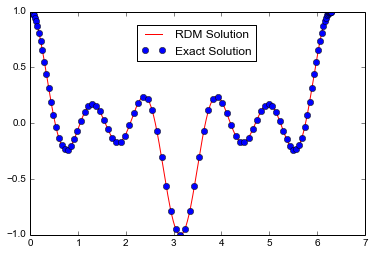

In [35]:
xx=linspace(0,2*pi,1000)
u_exact=lambda xx: 1/3.*(cos(xx)+cos(3*xx)+cos(5*xx))
u_poly=bary2(xx,xk,u,wk)
#plt.plot(xx,u_exact(xx))
plt.figure()
plt.plot(xx,u_poly,"r",label = "Spectral RDM Solution")
plt.plot(xk,u,"o",label = "Exact Solution")
#plt.figure()
#plt.plot(xk,u_exact(xk)-u,'o')
#_=plt.axis('equal')
plt.legend([ 'RDM Solution', 'Exact Solution' ],bbox_to_anchor=[0.3,0.75], loc='lower left', ncol=1)
#plt.legend()

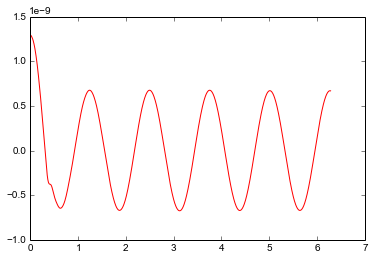

In [36]:
plt.figure()
plt.plot(xx,u_exact(xx)-u_poly,"r")

## Problem with complex roots
$$u'' +u=0.001e^{ix}$$

$$u(0)=1$$

$$u'(0)=0.9995i$$

In [37]:
N=160
xk=(chebpts(N)+1)/2.*40*pi
wk=chebwts(N)
yk=(chebpts1(N-1)+1)/2.*40*pi
D=diffmat(xk)
P=barymat(yk,xk,wk)
D2=dot(D,D)
A=zeros((N+1,N+1),dtype=complex)
A[2:,:]=dot(P,D2+eye(N+1))
A[0,0]=1.
A[1,:]=D[0,:]
rhs=zeros(N+1,dtype=complex)
rhs[2:]=dot(P,0.001*exp(1j*xk))
rhs[0]=1.
rhs[1]=0.9995j

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


In [38]:
u=solve(A,rhs)
abs(u)

array([ 1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
        1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
        1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0001,  1.0002,  1.0002,  1.0002,  1.0002,  1.0002,  1.0002,
        1.0002,  1.0002,  1.0002,  1.0003,  1.0003,  1.0003,  1.0003,  1.0003,  1.0003,  1.0004,  1.0004,  1.0004,  1.0004,  1.0004,  1.0004,  1.0005,  1.0005,  1.0005,  1.0005,  1.0005,  1.0006,
        1.0006,  1.0006,  1.0006,  1.0006,  1.0007,  1.0007,  1.0007,  1.0007,  1.0008,  1.0008,  1.0008,  1.0008,  1.0008,  1.0009,  1.0009,  1.0009,  1.0009,  1.001 ,  1.001 ,  1.001 ,  1.001 ,
        1.0011,  1.0

In [39]:
ux_exact=lambda x:cos(x)+0.0005*x*sin(x)
uy_exact=lambda x: sin(x)-0.0005*x*cos(x)
u_exact= lambda x:ux_exact(x)+uy_exact(x)*1j

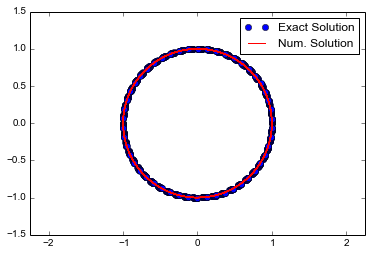

In [40]:
xx=linspace(0,40*pi,1000)
u_poly=bary2(xx,xk,u,wk)
plt.plot(ux_exact(xx),uy_exact(xx),"o",label = "Exact Solution")
plt.plot(u_poly.real,u_poly.imag, "r", label = "Num. Solution ")
_=plt.axis('equal')
plt.legend()

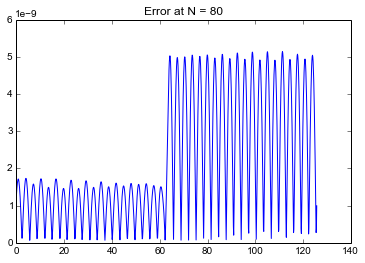

In [41]:
plt.plot(xx,abs(u_exact(xx)-u_poly))
plt.title('Error at N = 80')

In [42]:
#Our method 
1.0019719765344917 -1.0019719839296723 
#Lambert and Watson
s = 1.0019719765344917
s - 1.001829
#cash
1.0019719765344917 - 1.0002057
#Fatunla et al
1.0019719765344917 - 1.0020842

-0.00011222346550843199

# Non-linear

# Airy equation      source: Driscoll et al 2016 pg 4

$$u^{\prime \prime} - xu = 1$$

with boundary condition $u(-30)=0$, $u(30)=4$

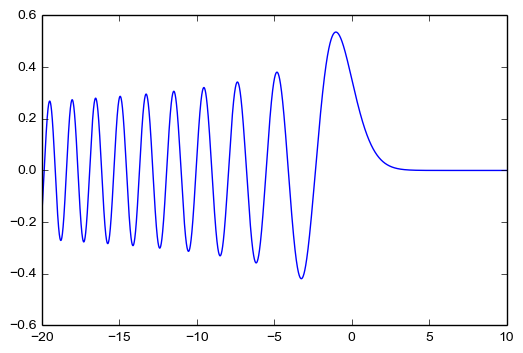

In [37]:
from scipy import special
xx=linspace(-20,10,10000)
yy=special.airy(xx)[0]
plt.plot(xx,yy)
#plt.plot(xx,yy)

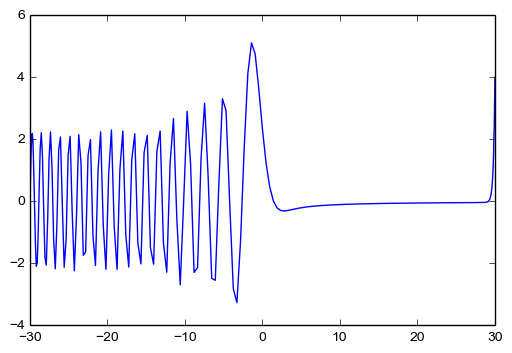

In [38]:
N=200
xk=30*chebpts(N)
#a=0
#b=10
#xk=(b-a)/2*(xk+1)+a

D=diffmat(xk)
D2=dot(D,D)
h=lambda u: dot(D2,u) - xk*u #matrix from the system
hp=lambda u: D2-diag(xk) # differentiated matrix from the system
f=ones(N+1)
du=zeros(N+1)
u0=zeros(N+1)
u=u0
u[0]=0.
u[-1]=4.
for i in range(20):
    A=hp(u)
    rhs=f-h(u)    #newton iterative scheme
    A[0,:]=0;A[0,0]=1
    A[-1,:]=0;A[-1,-1]=1
    rhs[0]=0
    rhs[-1]=0
    du=solve(A,rhs);
    
    u=u+du
plt.plot(xk,u)

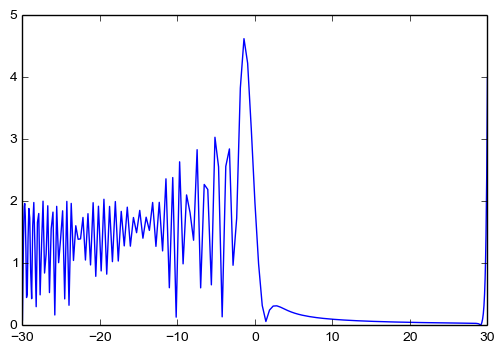

In [39]:
from scipy import special
yy=special.airy(xk)[0]
plt.plot(xk,abs(u-yy))

# $u'=u^2+1, u(0)=1$, $[0,1] =[x_{n},x_{n+1}]$ MNO IKHILE 2001 pg 553   $h = \frac{x_{n+1}-x_{n}}{N}$ $h= \frac{1}{20}$ I worked this out to get $N=20$

In [40]:
N=20
xk=0.07*(chebpts(N)+1.) # scaling to a point before the singularity
#a=0
#b=10
#xk=(b-a)/2*(xk+1)+a
D=diffmat(xk)
#D2=dot(D,D)
h=lambda u: (dot(D,u)) - u*u
hp=lambda u: D-2*diag(u)
f=ones(N+1)

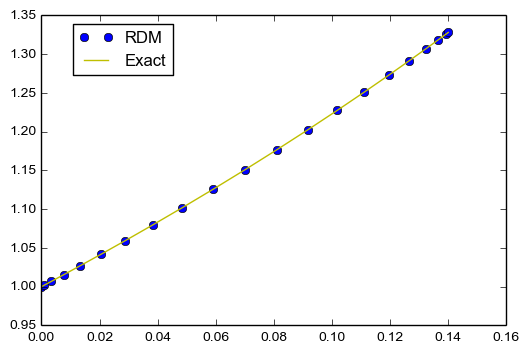

In [41]:
u0=zeros(N+1)
u0[0]=1
u=u0
for i in range(20):
    A=hp(u)
    rhs=f-h(u)
    A[0,:]=0;A[0,0]=1
    #A[-1,:]=0;A[-1,-1]=1
    rhs[0]=0
    #rhs[-1]=0
    du=solve(A,rhs)
    u=u+du
    #print(norm(du))
    #exact = tan(xk + pi/4.)
    #plt.plot(xk, abs(u-exact))
    #print(u)
    exact = tan(xk + pi/4.)
plt.plot(xk, u,'o')
plt.plot(xk, exact,'y')
plt.legend([ 'RDM', 'Exact'],bbox_to_anchor=[0.3, 1], loc='upper right', ncol=1)
plt.show()

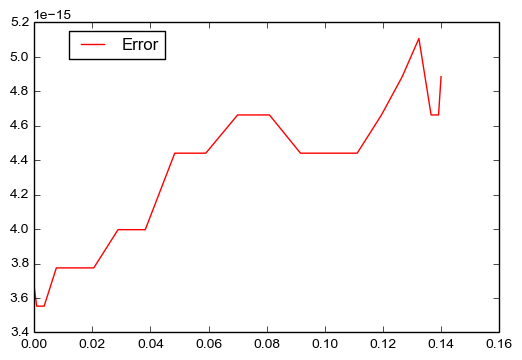

In [42]:
plt.plot(xk, abs(u-exact),'r')
plt.legend([ 'Error'],bbox_to_anchor=[0.3, 1], loc='upper right', ncol=1)

In [43]:
print(max(abs(u-exact)))

5.10702591328e-15


# Vanderpool Equation  (source: CHEBFUN SITE AND MNO IKHILE 2001 pg 554)  $u''-\nu (1-u^2)u' + u=0, x \in [0,1], u(0)=2, u'(0)=0, v=15 or 50$

http://www.chebfun.org/examples/ode-nonlin/IVPCapabilities.html
To solve this ODE with $\mu = 5$ for $t \in [0,50]$ with initial conditions $u(0) = 0.1, \, u'(0) = 0$, we proceed as follows.

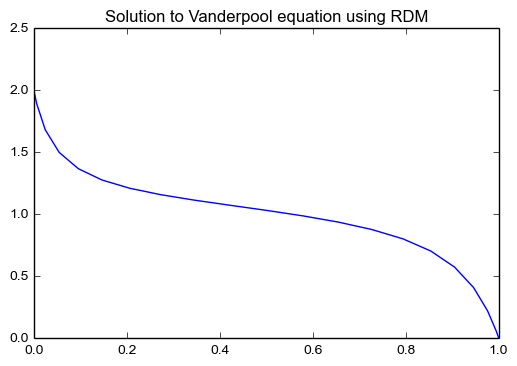

In [44]:
N=20
xk=0.5*(chebpts(N)+1.)
v=15
#a=0
#b=10
#xk=(b-a)/2*(xk+1)+a
D=diffmat(xk)
D2=dot(D,D)
h=lambda u: dot(D2,u)-v*dot(D,u) +v*u*u*dot(D,u) + u
hp=lambda u: D2-v*D + v*2*diag(u*dot(D,u))+v*dot(diag(u*u),D)+diag(u)
#(dot(D,-2*diag(u)))+dot(diag(u),D)+ diag(u)
f=zeros(N+1)

u0=zeros(N+1)
u0[0]=2.
u0[-1]=0
u=u0
for i in range(20):
    A=hp(u)
    rhs=f-h(u)
    A[0,:]=0;A[0,0]=1
    A[-1,:]=0;A[-1,-1]=1
    rhs[0]=0
    rhs[-1]=0
    du=solve(A,rhs)
    u=u+du
    #print(norm(du))
plt.title('Solution to Vanderpool equation using RDM')
plt.plot(xk,u)

(-20, 20)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


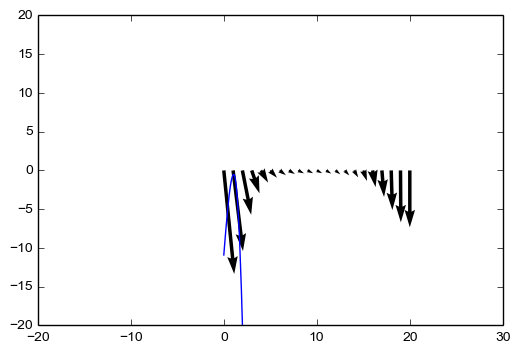

In [45]:
#PHASE PLOT
import numpy as np
plt.plot(u,dot(D,u))
plt.quiver(u,dot(D,u))
plt.xlim(-20,30)
plt.ylim(-20,20)

# Source: Samia et all 2016 HAT DATA

$$\begin{array}{|c|l|c|c|}
\hline 
Parameter & Definition & Value & Unit \\ 
\hline 
H_{s0} & Initial population for susceptible humans & 5000 & human \\ 
\hline 
H_{i0} & Initial population for infected humans &  30 & human \\ 
\hline 
T_{s0} & Initial population for susceptible tsetse flies  & 50000 & tsetse\\ 
\hline 
T_{i0} & Initial population for infected tsetse flies  & 140 & tsetse\\ 
\hline 
\pi & Birth rate in susceptible humans &  0.27 &human day^{-1}\\ 
\hline 
\mu & Natural death in humans &  1/18250 & days^{-1} \\ 
\hline 
\gamma & HAT induced death of an infected humans &  1/180 & days^{-1} \\ 
\hline 
\beta & Infection rate in susceptible humans & 9.12e-6 & day^{-1} tsetse^{-1} \\ 
\hline 
\delta & Recovery rate in infected humans & 1/14 & days^{-1} \\ 
\hline 
\psi & Birth rate in susceptible tsetse flies& 20 & tsetse human^{-1} \\ 
\hline 
\alpha & Infection rate in susceptible tsetse flies & 1.5e-5 & human^{-1} days^{-1}  \\ 
\hline 
\omega & Death rate in tsetse flies & 1/40 & days^{-1} \\ 
\hline 
\end{array}
$$

In [46]:
from numpy import round
import scipy.integrate as spi

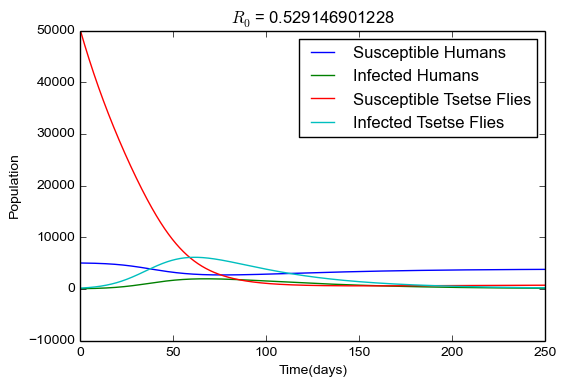

0.529146901228


In [47]:
def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
omega=1/40

#reproduction number
R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))

#Solving the model for 250 days
t = np.linspace(0, 250, 10001)
solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       
Hs = solution[:, 0]
Hi = solution[:, 1]
Ts = solution[:, 2]
Ti = solution[:, 3]
plt.plot(t, Hs)
plt.plot(t, Hi)
plt.plot(t, Ts)
plt.plot(t, Ti)
plt.ylim(-10000,50000)
plt.xlabel('Time(days)')
plt.ylabel('Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.title('$R_{0}$ = 0.529146901228')
plt.show()
print(R0)

In [48]:
#The basic reproduction number is the probability that an infected human or fly will infect a susceptible human or fly
print("R0 :",R0)

R0 : 0.529146901228


In [49]:
A=np.zeros((len(t),2))
#B=np.zeros((len(t),2))
A[:,0]=Hi
A[:,1]=t
#B[:,0]=Ti
#B[:,1]=t
i=0
#j=0
while A[i][0]!=max(Hi):
   # while B[j][0]!=max(Ti):
        i=i+1
        #j=j+1
print([max(Hi),t[i]])
#print([max(Ti),t[j]])


[1941.3255831730571, 67.350000000000009]


In [50]:
#ALTERNATIVE METHOD
# Time at which the maximum Infection occur in Infected human

ind_max=Hi.argmax()
print([Hi[ind_max],t[ind_max]])

[1941.3255831730571, 67.350000000000009]


In [51]:
# Time at which the maximum Infection occur in Infected fly
B=np.zeros((len(t),2))
#A[:,0]=Hi
#A[:,1]=t
B[:,0]=Ti
B[:,1]=t
#i=0
j=0
#while A[i][0]!=max(Hi):
while B[j][0]!=max(Ti):
        #i=i+1
        j=j+1
#print([max(Hi),t[i]])
print([max(Ti),t[j]])

[6104.199855022578, 61.425000000000004]


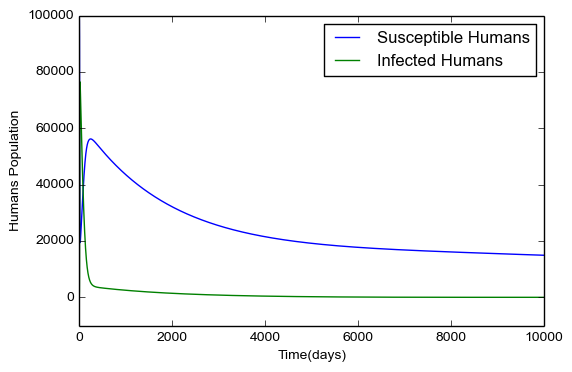

In [52]:
#considering human population. What will happen in the future
def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 100000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
omega=1/40

#reproduction number
R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))

t = np.linspace(0, 10000, 10001)
solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       
Hs = solution[:, 0]
Hi = solution[:, 1]
Ts = solution[:, 2]
Ti = solution[:, 3]
plt.plot(t, Hs)
plt.plot(t, Hi)
#plt.plot(t, Ts)
#plt.plot(t, Ti)
plt.ylim(-10000,100000)
#plt.xlim(-1000,10000)
plt.xlabel('Time(days)')
plt.ylabel('Humans Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans'])
plt.show()

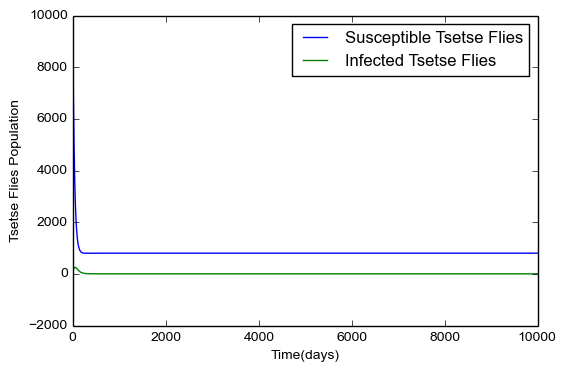

In [53]:
#considering tsetse fly population. What will happen in the future
def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 10000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
omega=1/40

#reproduction number
R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))

t = np.linspace(0, 10000, 10001)
solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       
Hs = solution[:, 0]
Hi = solution[:, 1]
Ts = solution[:, 2]
Ti = solution[:, 3]
#plt.plot(t, Hs)
#plt.plot(t, Hi)
plt.plot(t, Ts)
plt.plot(t, Ti)
plt.xlabel('Time(days)')
plt.ylabel('Tsetse Flies Population')
plt.legend([ 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.show()

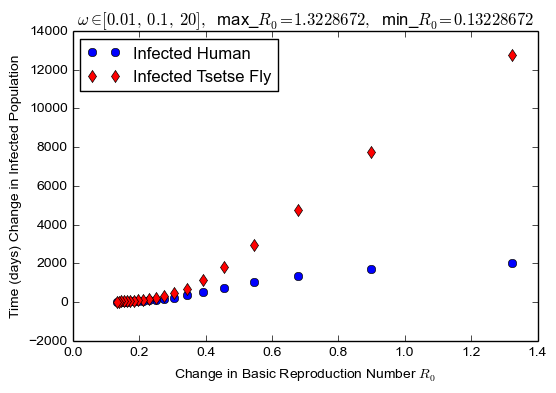

1.32286725307
0.132286725307


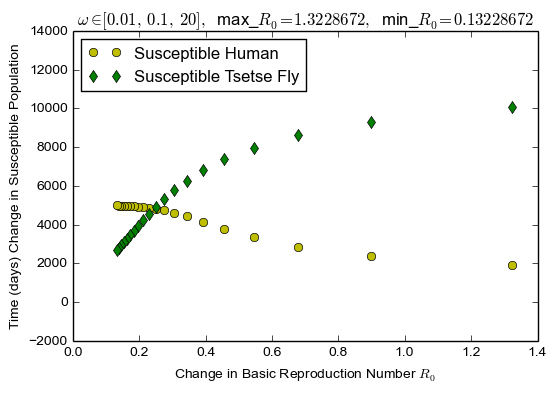

1.32286725307
0.132286725307


In [54]:
def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
t = np.linspace(0, 200, 10001)
Omega= np.linspace(0.01,0.1,20)
AVG_Ti = []
AVG_Hi = []
RR0 = []
for omega in Omega:
    #reproduction number
    R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))
    RR0.append(R0)
    #t = np.linspace(0, 200, 10001)
    solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       

    Hi = solution[:, 1]
    Ti = solution[:, 3]
    AVG_Ti.append(np.mean(Ti))
    AVG_Hi.append(np.mean(Hi))
    #plt.plot(t, Hs)
    #plt.plot(t, Hi)
    #plt.plot(t, Ts)
plt.xlabel('Change in Basic Reproduction Number $R_{0}$')
plt.ylabel('Time (days) Change in Infected Population')
plt.plot(RR0, AVG_Hi,'o')
plt.plot(RR0, AVG_Ti,'dr')
#plt.ylim(-10000,50000)
#plt.xlabel('Time(days)')
#plt.ylabel('Population')
#plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.ylim(-2000,14000)
plt.legend([ 'Infected Human', 'Infected Tsetse Fly'],bbox_to_anchor=[0.46, 1], loc='upper right', ncol=1)
plt.title('$\omega \in [0.01,\, 0.1, \, 20],\;$max_$R_{0} = 1.3228672,\;$min_$R_{0} = 0.13228672$')
#0.04,0.2,20
plt.show()
print(np.max(RR0))
print(np.min(RR0))



def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
t = np.linspace(0, 200, 10001)
Omega= np.linspace(0.01,0.1,20)
AVG_Ts = []
AVG_Hs = []
RR0 = []
for omega in Omega:
    #reproduction number
    R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))
    RR0.append(R0)
    #t = np.linspace(0, 200, 10001)
    solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       

    Hs = solution[:, 0]
    Ts = solution[:, 2]
    AVG_Ts.append(np.mean(Ts))
    AVG_Hs.append(np.mean(Hs))
    #plt.plot(t, Hs)
    #plt.plot(t, Hi)
    #plt.plot(t, Ts)
plt.xlabel('Change in Basic Reproduction Number $R_{0}$')
plt.ylabel('Time (days) Change in Susceptible Population')

plt.plot(RR0, AVG_Hs,'oy')
plt.plot(RR0, AVG_Ts,'dg')

#plt.ylim(-10000,50000)
#plt.xlabel('Time(days)')
#plt.ylabel('Population')
#plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.ylim(-2000,14000)
plt.legend([ 'Susceptible Human', 'Susceptible Tsetse Fly'],bbox_to_anchor=[0.52, 1], loc='upper right', ncol=1)
plt.title('$\omega \in [0.01,\, 0.1, \, 20],\;$max_$R_{0} = 1.3228672,\;$min_$R_{0} = 0.13228672$')
#0.04,0.2,20
plt.show()
print(np.max(RR0))
print(np.min(RR0))


In [55]:
from numpy import *
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import *
# Set up some basic functions
def barywts(x):
    w=prod(x[:,newaxis]-x+eye(len(x)),1)
    w=1./w
    return w

# Differentiation matrix
def diffmat(x):
    N=len(x) # Size of 
    w=barywts(x) # Compute the barycentric weights for x
    D=zeros((N,N)) # initialize the differentiation matrix
    for i in range(N):
        D[i,:]=w/w[i]/(x[i]-x) # Formulat we derived by differentiating each lagrange polynomial and evaluating at the same nodes
        D[i,i]=0. # Set the i,i entry to zero so we can sum the rows to get the diagonal entry.
        D[i,i]=-sum(D[i,:])
    #D=((w[:,newaxis]/w)/(x[:,newaxis]-x+eye(N))-eye(N))
    #for j in range(N):
    #    D[j,j]=-sum(D[j,:])
    return D

def chebpts(NN):
    return cos(np.pi*arange(NN+1)/NN)[::-1]

def bary_cheb(x, fk):
    """Evaluate p(x) using the barycentric formula 
    where fk are values of p(x) at the chebyshev points"""
    # First initialize the numerator and denominator sums
    numer = zeros(x.size)
    denom = zeros(x.size)
    xk = chebpts(fk.size-1)
    # loop over all interpolation nodes
    for j in range(xk.size):
        term_den = (-1 if j%2 else 1)/(x-xk[j])
        term_num = fk[j]*term_den
        if j == 0 or j == xk.size-1:
            term_num /= 2.0; term_den /= 2.0
        numer += term_num
        denom += term_den
    return numer / denom


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide


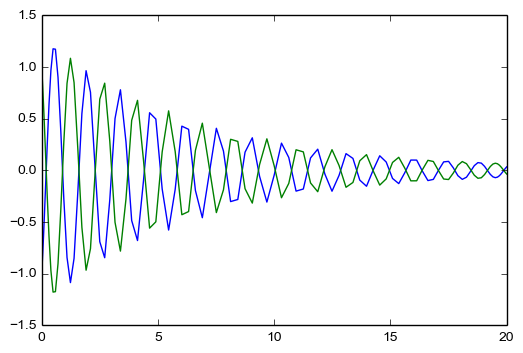

In [56]:
#Setting up A MATRIX
def Hp(u):
    A = zeros((len(u),len(u)))

N=100
tk=20*0.5*(chebpts(N)+1)
D=diffmat(tk)
D2=dot(D,D)
A=zeros((2*(N+1),2*(N+1)))
I=eye(N+1)
m=1.
k=4.
c=0.3

#Setting up the element in the matrix
A11=m*D2+c*D+k*k*I
A12=-k*I
A21=-k*I
A22=m*D2+c*D+k*k*I

## Enforcing the boundary conditions in each of the blocks, we will use the first block rows
## to enforce the boundary conditions for $x_1(t)$ and the second block rows for $x_2(t)$
A11[0:1,:]=0.
A11[0,0]=1.
A11[1,:]=D[0,:]
A12[0:1,:]=0.

A21[0:1,:]=0.
A22[0:1,:]=0.
A22[0,0]=1.
A22[1,:]=D[0,:]

A=r_[c_[A11,A12],c_[A21,A22]]# r _ concatinate two metrices together block row
rhs1=zeros(N+1);rhs2=zeros(N+1) #c_concatinate
rhs1[0]=-1.
rhs1[1]=0.
rhs2[0]=1.
rhs2[1]=0.
rhs=r_[rhs1,rhs2] #concatination 

u=solve(A,rhs)
x1=u[0:N+1]
x2=u[N+1:]
(x1.shape,x2.shape,tk.shape)

plt.plot(tk,x1,tk,x2)


    

HAT MODEL

\begin{equation}
     \begin{array}{l}
    dHs =  \pi - \beta Hs Ti - \mu Hs + \delta Hi \\
    dHi =  \beta Hs Ti - (\mu + \gamma + \delta)Hi\\
    dTs =  \psi - \alpha Hi Ts - \omega Ts\\
    dTi = \alpha Hi Ts - \omega Ti
    \end{array}
\end{equation}


With solution variables $u$ given by
$$
u=\left[\begin{array}{c}Hs\\Hi\\ Ts\\  Ti\end{array}\right]
$$



Differentiating with respect to the variables $H_s(t)$, $H_i(t)$, $T_s(t)$, and $T_i(t)$. This gives the matrix $A$:
$$
A=
\left[
\begin{array}{cccc}
 D+\beta\mathrm{diag}(Ti)  + \mu I & -\delta I &0& \beta\mathrm{diag}(Hs) \\
-\beta\mathrm{diag}(Ti)   & D +(\mu + \omega +\mu)I   &0&-\beta\mathrm{diag}(Hs)\\
0 & \alpha \mathrm{diag}(Ts) &D + \alpha\mathrm{diag}(Hi) - \omega I &0 \\
0 & -\alpha \mathrm{diag}(Ts)& -\alpha\mathrm{diag}(Hi) &  D+\omega I\\
\end{array}
\right]
$$
Here we are going to define our solution $u$ as
$$u=\left[\begin{array}{c}H_s(t)\\ H_i(t)\\ T_s(t)\\ T_i(t)\end{array}\right]$$

$$
A11= D+T_i(t) \beta + \mu \quad
A12= -\delta \quad
A13= 0 \quad
A14= H_s(t) \beta \quad
A21= -T_i(t) \beta \quad
A22= D +(\mu + \omega +\mu) \quad
A23= 0 \quad
A24= -H_s(t) \beta \quad
A31= 0 \quad
A32= \alpha T_s(t) \quad
A33= D + H_i(t) \alpha - \omega \quad
A34= 0 \quad
A41= 0 \quad
A42= -\alpha T_s(t) \quad
A43= -\alpha H_i(t) \quad
A44= D+\omega \quad
$$

In [59]:
#BIG = (N,t,beta, gamma, pi, mu, delta, psi, alpha, omega)
#del BIG
N=80

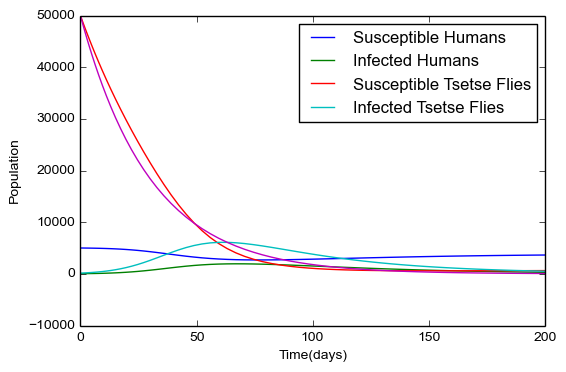

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in true_divide


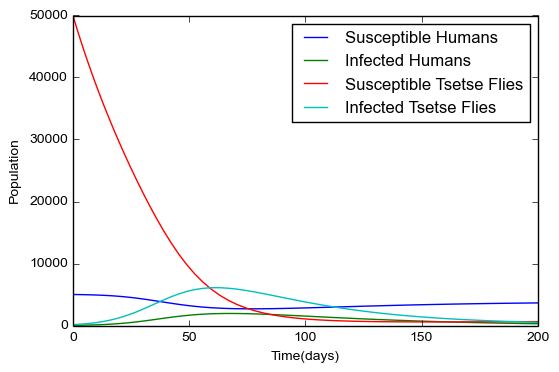

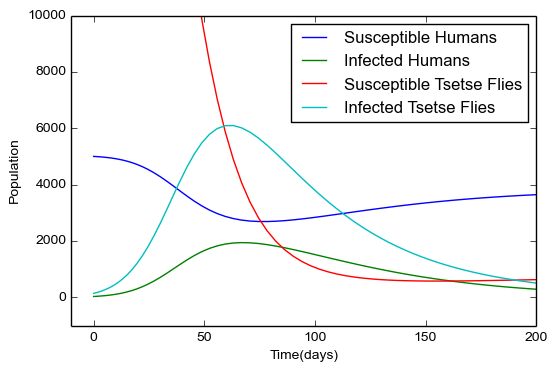

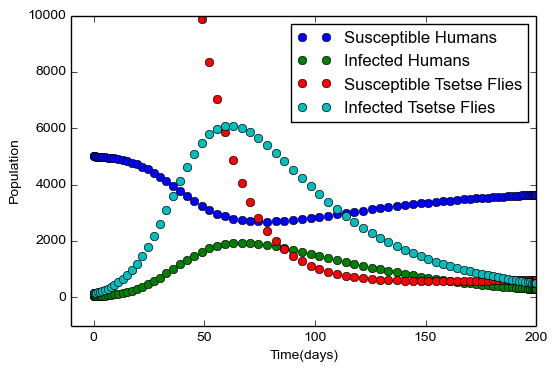

In [60]:
def HAT_MODEL(Y,t,beta, gamma, pi, mu, delta, psi, alpha, omega):
    
    #INITIAL CONDITIONS FOR THE STATE VARIABLES
    Hs =Y[0]
    Hi =Y[1]
    Ts =Y[2]
    Ti =Y[3]
    N1 =Hs + Hi 
    N2 =Ts + Ti
    
    #THE HAT MODEL
    dHs =  pi - beta*Hs*Ti - mu*Hs + delta*Hi
    dHi =  beta*Hs*Ti - (mu + gamma + delta)*Hi
    dTs =  psi - alpha*Hi*Ts - omega*Ts
    dTi =  alpha*Hi*Ts - omega*Ti
    dY =   [dHs, dHi, dTs, dTi]
    return dY

#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
omega=1/40

#reproduction number
R0 = np.sqrt((alpha*beta*pi*psi)/((delta*omega + gamma*omega + mu*omega)*(mu*omega)))

#t = np.linspace(0, 250, 10001)
t = 200*0.5*(chebpts(N-1)+1)
solution = spi.odeint(HAT_MODEL,[Hs0,Hi0,Ts0,Ti0],t,args = (beta, gamma, pi, mu, delta, psi, alpha, omega))       
Hs = solution[:, 0]
Hi = solution[:, 1]
Ts = solution[:, 2]
Ti = solution[:, 3]
plt.plot(t, Hs)
plt.plot(t, Hi)
plt.plot(t, Ts)
plt.plot(t, Ti)
plt.plot(t,50000*np.exp(-1/30.*t))
plt.ylim(-10000,50000)
plt.xlabel('Time(days)')
plt.ylabel('Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.show()
u=r_[Hs,Hi,Ts,Ti]
u0=u.copy()

N=80
#tk=200*0.5*(chebpts(N-1)+1)
tk=100*(chebpts(N-1)+1)
D=diffmat(tk)
I=eye(N)
#state variables
Hs0  = 5000
Hi0  = 30
Ts0  = 50000
Ti0  = 140

#Human parameters
beta = 9.12*(10**-6)
gamma= 1/180
pi   = 0.27
mu   = 1/18250
delta= 1/14

#Tsetse parameters
psi  = 20
alpha= 1.5*(10**-5)
omega=1/40

def h_HAT(u):
    # First we split up the vector u into the variables (Hs,Hi,Ts,Ti)
    N=int(len(u)/4)
    #print(N,D.shape)
    Hs=u[:N]; Hi=u[N:2*N];Ts=u[2*N:3*N];Ti=u[3*N:] #extracting (element 2n to 3n-1....: to the end ogf the matrix)
    
    # Now we fill in each of the blocks of the matrix
    A=zeros((4*N))
    A[:N]      = dot(D,Hs) + Hs*Ti*beta - Hi*delta + Hs*mu
    A[N:2*N]   = dot(D,Hi) - Hs*Ti*beta + Hi*(delta+gamma+mu)
    A[2*N:3*N] = dot(D,Ts) + Hi*Ts*alpha + Ts*omega
    A[3*N:4*N] = dot(D,Ti) - Hi*Ts*alpha + Ti*omega

    return A

def hp_HAT(u):
    # First we split up the vector u into the variables (Hs,Hi,Ts,Ti)
    N=int(len(u)/4)
    Hs=u[:N]; Hi=u[N:2*N];Ts=u[2*N:3*N];Ti=u[3*N:] #extracting (element 2n to 3n-1....: to the end ogf the matrix)
    
    # Now we fill in each of the blocks of the matrix
    A=zeros((4*N,4*N))
    A[:N,:N]=D+diag(Ti)*beta + mu*I 
    A[:N,N:2*N]=-delta*I
    A[:N,3*N:]=diag(Hs)*beta
    A[N:2*N,:N]=-diag(Ti)*beta
    A[N:2*N,N:2*N]=D+I*(mu+omega+mu)
    A[N:2*N,3*N:]=-diag(Hs)*beta
    A[2*N:3*N,N:2*N]=alpha*diag(Ts)
    A[2*N:3*N,2*N:3*N]=D+diag(Hi)*alpha+omega*I
    A[3*N:,N:2*N]=-alpha*diag(Ts)
    A[3*N:,2*N:3*N]=-alpha*diag(Hi)
    A[3*N:,3*N:]=D+omega*I
    
    #Enforcing the boundary conditions
    A[0,:]=0
    A[0,0]=1
    A[N,:]=0
    A[N,N]=1
    A[2*N,:]=0
    A[2*N,2*N]=1
    A[3*N,:]=0
    A[3*N,3*N]=1
    
    return A

u = zeros((4*N))
u[0:N]=u0[:N]#5000
u[N:2*N]=u0[N:2*N]#30
u[2*N:3*N]=u0[2*N:3*N]#50000*exp(-1/30.*tk) Adjustment to the initial value
u[3*N:]=u0[3*N:]
#plt.plot(tk,u[0:N],tk,u[N:2*N],tk,u[2*N:3*N],tk,u[3*N:])
#plt.show()
u[0]= Hs0; u[N]=Hi0; u[2*N]=Ts0; u[3*N] = Ti0;
    
f = zeros(4*N)
f[:N]=pi
f[2*N:3*N]=psi

#print(u.shape, h_HAT(u).shape, f.shape)
for i in range(125):
    #print('Here')
    A=hp_HAT(u)
    rhs=f-h_HAT(u)
    rhs[0]=0
    rhs[N]=0
    rhs[2*N]=0
    rhs[3*N]=0
    du=solve(A,rhs)
    if False: #norm(du)>5:
        u=u+0.09*du   #using the newton damped technique (not to use all the solution, just part)
    else:
        u=u+du
    #print(norm(du))
    
    
Hs=u[:N]; Hi=u[N:2*N];Ts=u[2*N:3*N];Ti=u[3*N:]
plt.plot(tk,Hs)
plt.plot(tk,Hi)
plt.plot(tk,Ts)
plt.plot(tk,Ti)
plt.xlabel('Time(days)')
plt.ylabel('Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.show()
#print(u)

    
    
plt.plot(tk,Hs)
plt.plot(tk,Hi)
plt.plot(tk,Ts)
plt.plot(tk,Ti)
plt.ylim(-1000,10000)
plt.xlim(-10,200)
plt.xlabel('Time(days)')
plt.ylabel('Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.show()


plt.plot(tk,Hs,'o')
plt.plot(tk,Hi,'o')
plt.plot(tk,Ts,'o')
plt.plot(tk,Ti,'o')
plt.ylim(-1000,10000)
plt.xlim(-10,200)
plt.xlabel('Time(days)')
plt.ylabel('Population')
plt.legend([ 'Susceptible Humans', 'Infected Humans', 'Susceptible Tsetse Flies', 'Infected Tsetse Flies' ])
plt.show()

# barycentric formulas and weight

In [ ]:
# Set up some basic functions
def barywts(x):
    with errstate(divide='ignore',invalid='ignore'):
        w=prod(x[:,newaxis]-x+eye(len(x)),1)
    w=1./w
    return w

def bary_first(x, x_data, f):
    N = len(x_data)
    m = list(range(N))
    w = list(barywts(x_data))
    Lx = 1
    wi = []
    wifi = 0.
    for i in m:
        Lx = (x - x_data[i])*Lx
        wi.append(w[i]*f[i])
        wifi = (wi[i]/(x - x_data[i] )) + wifi
        first_kind = Lx*wifi
    return first_kind

def bary_second_kind(x, x_data, f):
    N = len(x_data)
    m = list(range(N))
    w = list(barywts(x_data))
    Lx = 1
    wi = []
    wifi = 0.
    for i in m:
        wi.append(w[i]*f[i])
        numerator = (wi[i]/(x - x_data[i] )) + wifi
        denominator = w[i]/(x - x_data[i])
    second_kind = numerator/denominator
    return second_kind

In [ ]:
u=arange(20)
A=hp_HAT(u)
plt.spy(A)
plt.savefig('spyHAT.eps', dpi=300)
plt.savefig('spyHAT.pdf', dpi=300)
plt.savefig('spyHAT.jpeg', dpi=300)



In [ ]:
plt.plot(h_HAT(u)-f)
norm(f-h_HAT(u))
plt.savefig('NormfA.eps', dpi=300)
plt.savefig('NormfA.pdf', dpi=300)
plt.savefig('NormfA.jpeg', dpi=300)